# **Simulazione dell'agente Soft Actor-Critic Stable Baselines3**

Il Soft Actor-Critic (SAC) è un algoritmo di Deep Reinforcement Learning caratterizzato dall'approccio off-policy e l'entropia. Inoltre, SAC è progettato per operare efficacemente con spazi d'azione continui, rendendolo ideale per ambienti complessi come CityLearn. Questa versione di SAC è direttamente implementata dalla libreria ed non necessita l'utilizzo di wrapper per l'ambiente, in quanto la normalizzazione degli spazi viene effettuata direttamente dall'agente. Questa simulazione considera inoltre il SACRBC, e effettua varie valutazioni su simulazioni con diversi reward.
Questa implementazione utilizza la versione di SAC implementata da **Stable Baselines3**.
Policy disponibili:

**MlpPolicy**: Oggetto policy che implementa l'attore-critico, utilizzando una rete MLP (2 strati da 64 neuroni)

**LnMlpPolicy**:Oggetto policy che implementa l'attore-critico, utilizzando una rete MLP (2 strati da 64 neuroni) con normalizzazione dei layer

**CnnPolicy**:Oggetto policy che implementa l'attore-critico, utilizzando una rete CNN (la "Nature CNN")

**LnCnnPolicy**:Oggetto policy che implementa l'attore-critico, utilizzando una rete CNN (la "Nature CNN") con normalizzazione dei layer

----

**Lista degli import**

In [43]:
from stable_baselines3.sac import SAC as Agent
from citylearn.citylearn import CityLearnEnv
from citylearn.reward_function import * 
from citylearn.wrappers import * 

from rewards.CityLearnReward import SolarPenaltyAndComfortReward



#import per strutture dati
import pandas as pd
from datetime import datetime

#import per grafici
from utils import plotting_functions as plt
from IPython.display import display, Markdown

#permette di nascondere i warning
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# Inizializza l'ambiente
# citylearn_challenge_2023_phase_2_local_evaluation è una simulazione nel mese di GIUGNO
env = CityLearnEnv('citylearn_challenge_2023_phase_2_local_evaluation', central_agent=True)

# Imposto un nuovo reward, rispetto a quello impostato di default

rf = SolarPenaltyAndComfortReward(env.schema)

env.reward_function = rf
# Imposto l'edificio di confronto e quanti episodi vengono effettuati dagli agenti
num_building = 0
num_episodes = 4

# Utilizzo i wrapper per normalizzare lo spazio (come fa di base l'implementazione di citylearn), e rendere compatibile con Stable Baselines
env = StableBaselines3Wrapper(env)

# Parametrizzo in maniera tale sia identico, non risultando equivalente all'implementazione di CityLearn
model = Agent(
    policy="MlpPolicy",
    env=env,
    buffer_size=100000,                # replay_buffer_capacity             
    batch_size=512,                    # batch_size
    ent_coef=0.2,                      # alpha (termine di entropia)
    target_update_interval=1,
    gradient_steps=2,                 # update_per_time_step
    verbose=1,
)

# Eseguo episodi di apprendimento
episodes = num_episodes
model.learn(total_timesteps=(env.unwrapped.time_steps*episodes), log_interval=None)

test_env = CityLearnEnv('citylearn_challenge_2023_phase_2_online_evaluation_3', central_agent=True)
rf = SolarPenaltyAndComfortReward(test_env.schema)

test_env.reward_function = rf
test_env = StableBaselines3Wrapper(test_env)
observations, _ = test_env.reset()
# ultimo episodio deterministico viene effettuato come segue
while not test_env.unwrapped.terminated:
    actions, _ = model.predict(observations, deterministic=True)
    observations, _, _, _, _ = test_env.step(actions)




Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


La funzione **learn()** esegue più episodi sull'ambiente: tutti tranne l'ultimo sono dedicati all'apprendimento, mentre l'ultimo viene eseguito in modalità **deterministic_finish**. In questa fase finale, l'agente utilizza esclusivamente la policy appresa per selezionare le azioni, senza ulteriori aggiornamenti o esplorazioni.


----

## **Confronto con Baseline**

In questa simulazione vengono esclusivamente confrontati gli algoritmi SAC e SACRBC, con il ComfortReward. La valutazione di altri reward viene lasciata alla relazione che raccoglierà solo i valori delle **cost_function**. I seguenti valori sono presi in considerazione come risultato di 4 episodi di training, in quanto risultano sufficienti al raggiungimento della convergenza.


In [45]:
# Vengono filtrare le cost_function desiderate
kpis_names = { 'electricity_consumption_total':'Consumo totale della rete',
               'carbon_emissions_total':'Emissioni',
              'discomfort_proportion':'Proporzione del tempo fuori dal comfort',
              'daily_peak_minus_load_factor_average': 'Misura dell inefficenza nell uso giornaliero della potenza disponibile',
              'daily_peak_average': 'Picco medio giornaliero',
              'all_time_peak_average': 'picco massimo dei consumi nel distretto',
              'one_minus_thermal_resilience_proportion': 'Discomfort proportion in interruzioni elettriche',
              'annual_normalized_unserved_energy_total': 'domanda non soddisfatta a causa di carenza di energia',
              'ramping_average': 'differenza media tra consumo al timestep corrente al precedente ',
              #Qua si aggiungono cost_function
}


display(Markdown(f"### **SAC - Stable Version**"))
display(Markdown("----"))

kpis = test_env.unwrapped.evaluate()
kpis = kpis[(kpis['cost_function'].isin(kpis_names))].dropna()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
display(kpis)



### **SAC - Stable Version**

----

name,Building_1,Building_2,Building_3,District
cost_function,,,,
all_time_peak_average,NaN,NaN,NaN,1.051
annual_normalized_unserved_energy_total,0.013,0.006,0.006,0.009
carbon_emissions_total,1.265,1.904,1.909,1.692
daily_peak_average,NaN,NaN,NaN,1.365
discomfort_proportion,0.779,0.704,0.631,0.704
electricity_consumption_total,1.282,1.898,1.905,1.695
one_minus_thermal_resilience_proportion,0.692,0.385,0.083,0.387
ramping_average,NaN,NaN,NaN,1.924



------

## **Comportamento dei consumi**

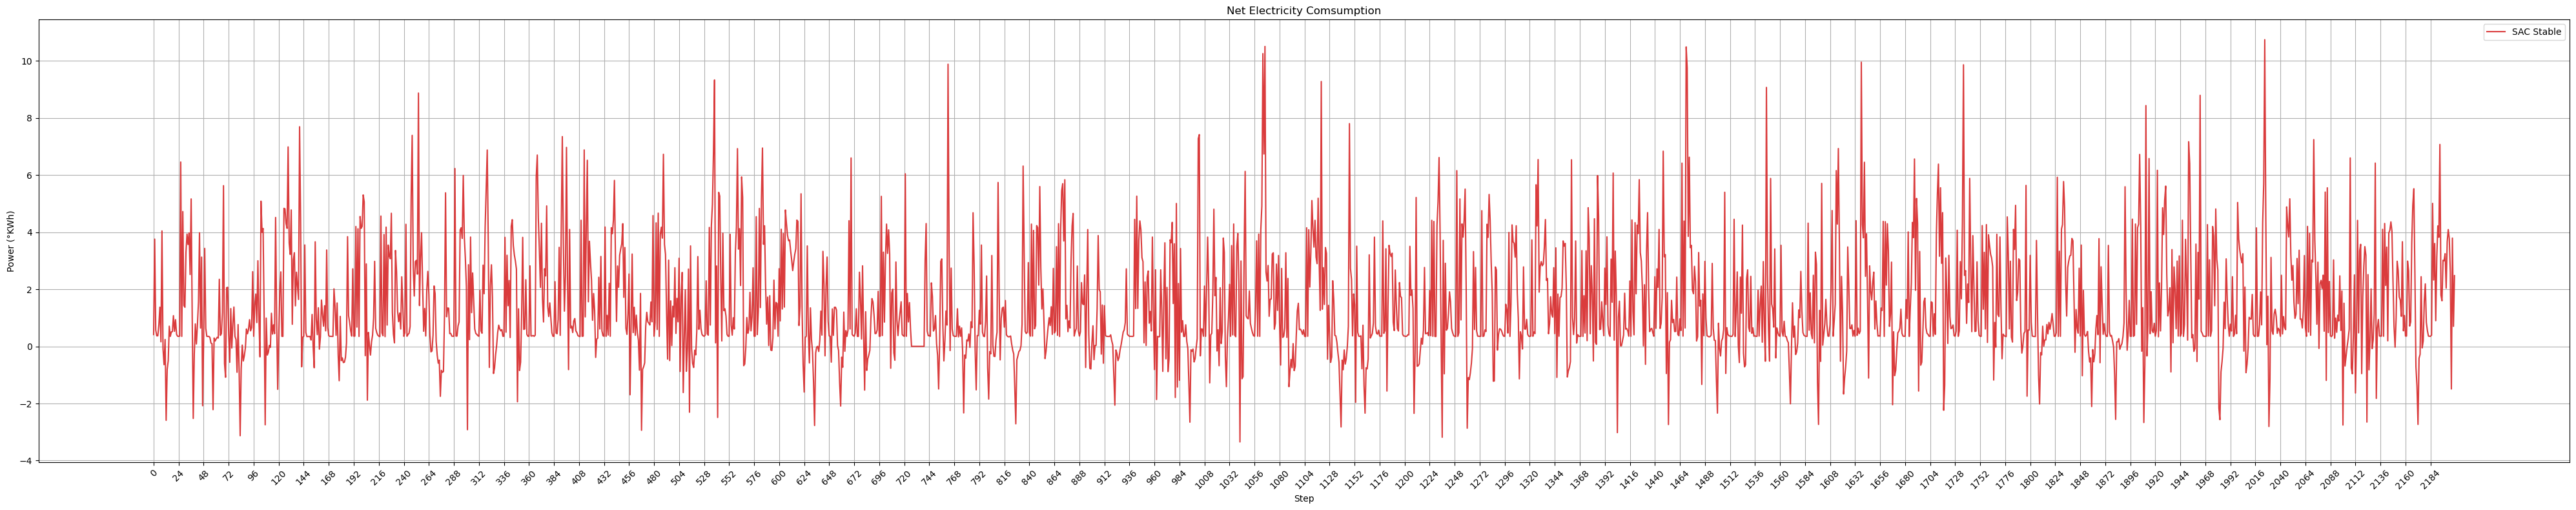

In [46]:
#Calcola il consumo di elettricità totale dell'edificio
energy_sac = test_env.unwrapped.buildings[num_building].net_electricity_consumption

plt.plot_single_agent(
    energy_sac,
    ylabel='Power (°KWh)',
    title='Net Electricity Comsumption',
    label='SAC Stable',
)


------

## **Comportamento delle temperature**

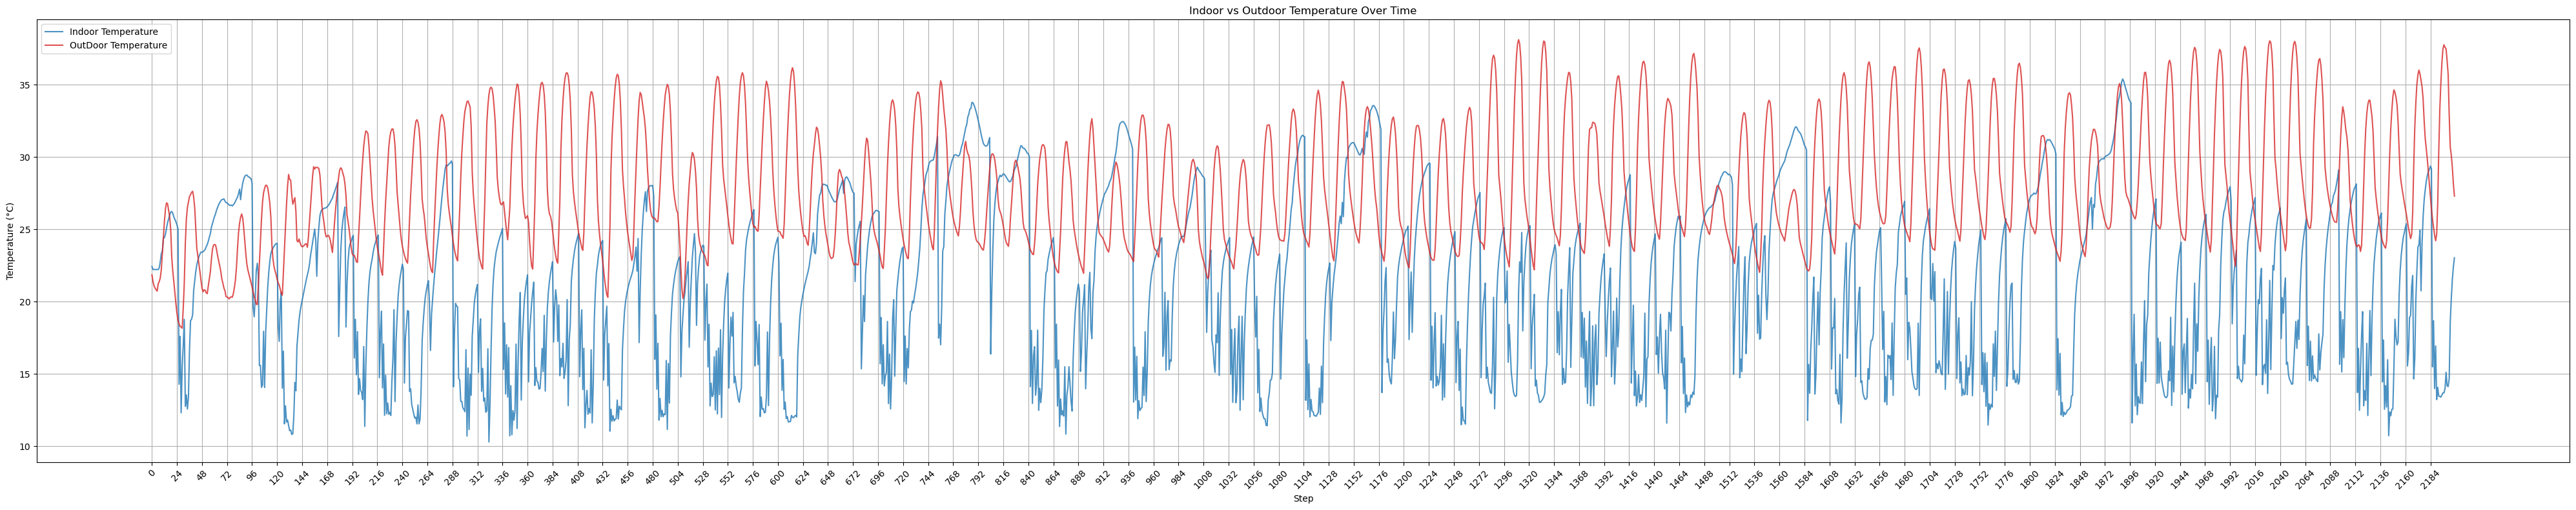

In [47]:
indoor_base_temp = test_env.unwrapped.buildings[num_building].indoor_dry_bulb_temperature
outdoor_temp = test_env.unwrapped.buildings[num_building].weather.outdoor_dry_bulb_temperature


plt.plot_comparison_two(
    indoor_base_temp,
    outdoor_temp,
    ylabel='Temperature (°C)',
    title='Indoor vs Outdoor Temperature Over Time',
    label1='Indoor Temperature',
    label2='OutDoor Temperature'
)


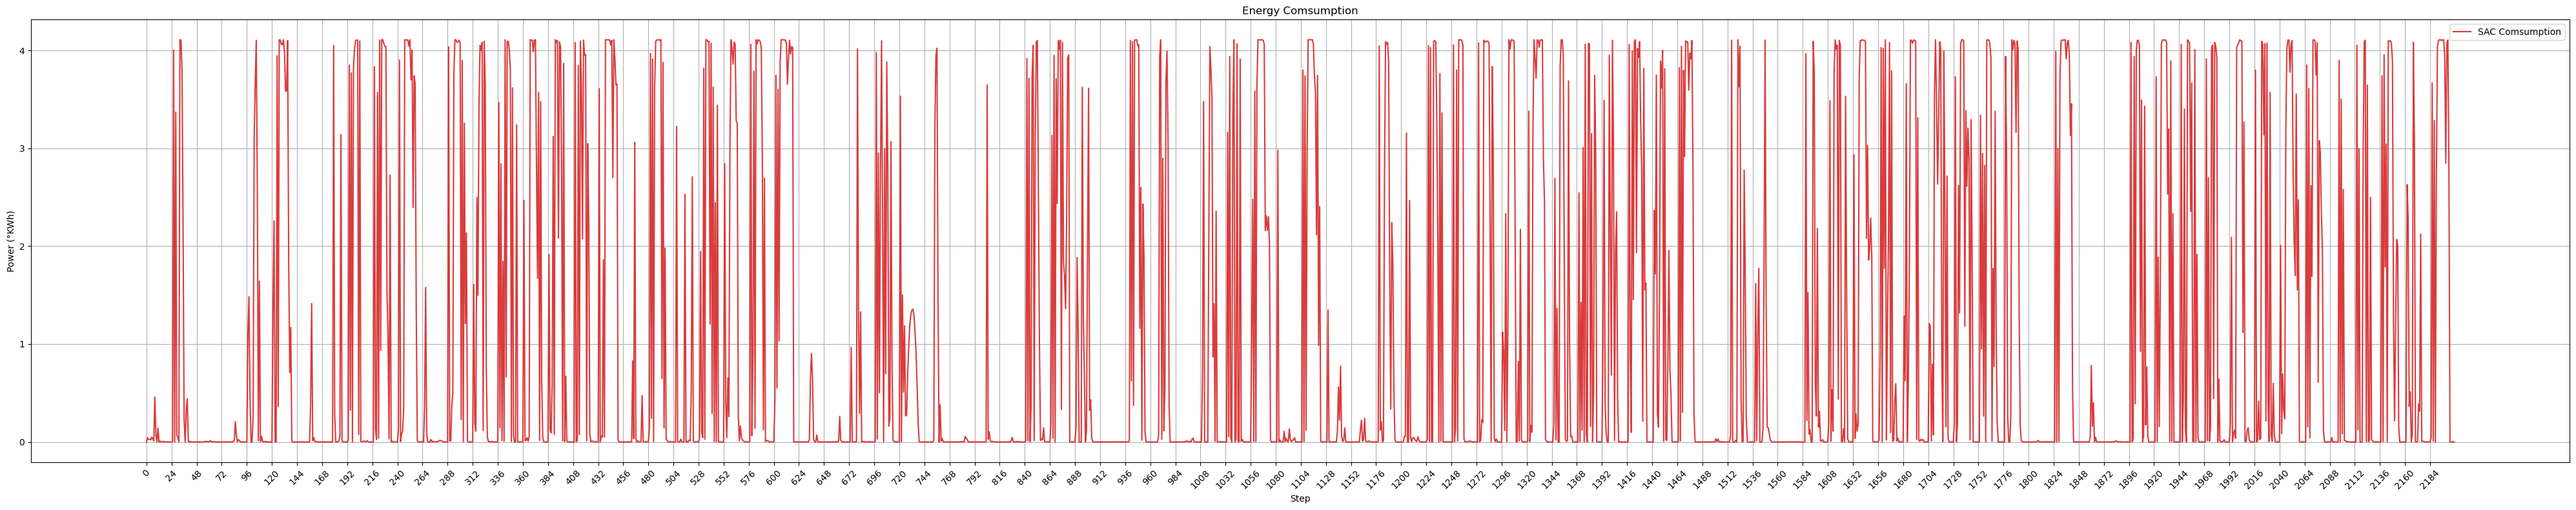

In [48]:
#Questa componente estrae la potenza utilizzata dei dispositivi che servono per regolare la temperatura ambientale

cooler_energy_sac = test_env.unwrapped.buildings[0].cooling_electricity_consumption

plt.plot_single_agent(
    cooler_energy_sac,
    ylabel='Power (°KWh)',
    title='Energy Comsumption',
    label='SAC Comsumption',

)


----

## **Comportamento nell'utilizzo delle batterie**

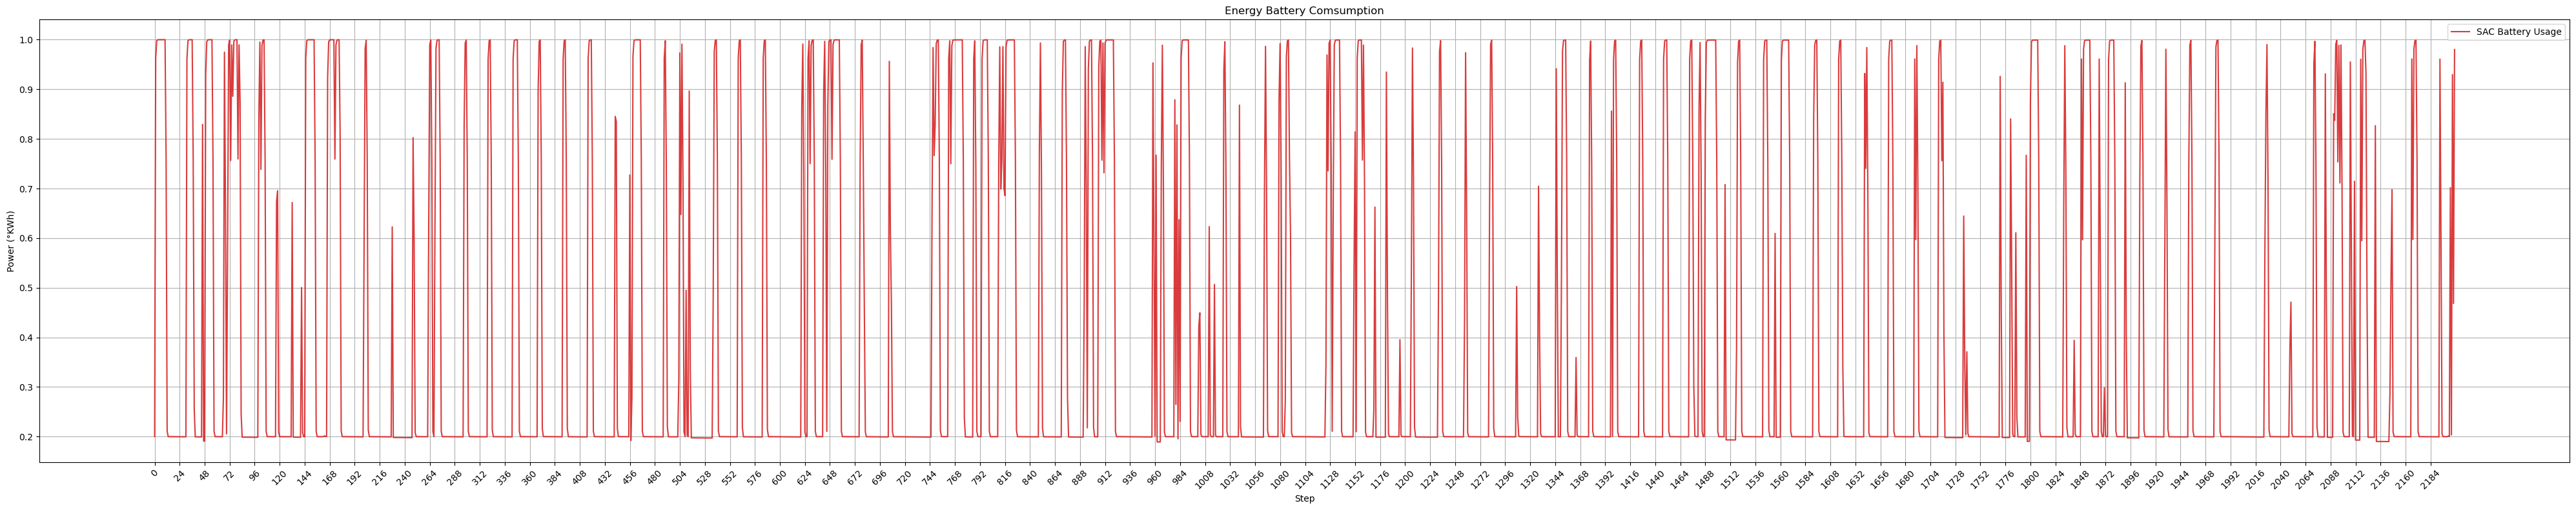

In [49]:
agent_data1 = test_env.unwrapped.buildings[num_building].electrical_storage.soc
plt.plot_single_agent(
    agent_data1,
    ylabel='Power (°KWh)',
    title='Energy Battery Comsumption',
    label='SAC Battery Usage'
)


----

## **Comportamento delle emissioni**

L'emissioni sono strettamente legate ai consumi di energia della rete, perciò le caratteristiche precedenti si propagano anche qua.

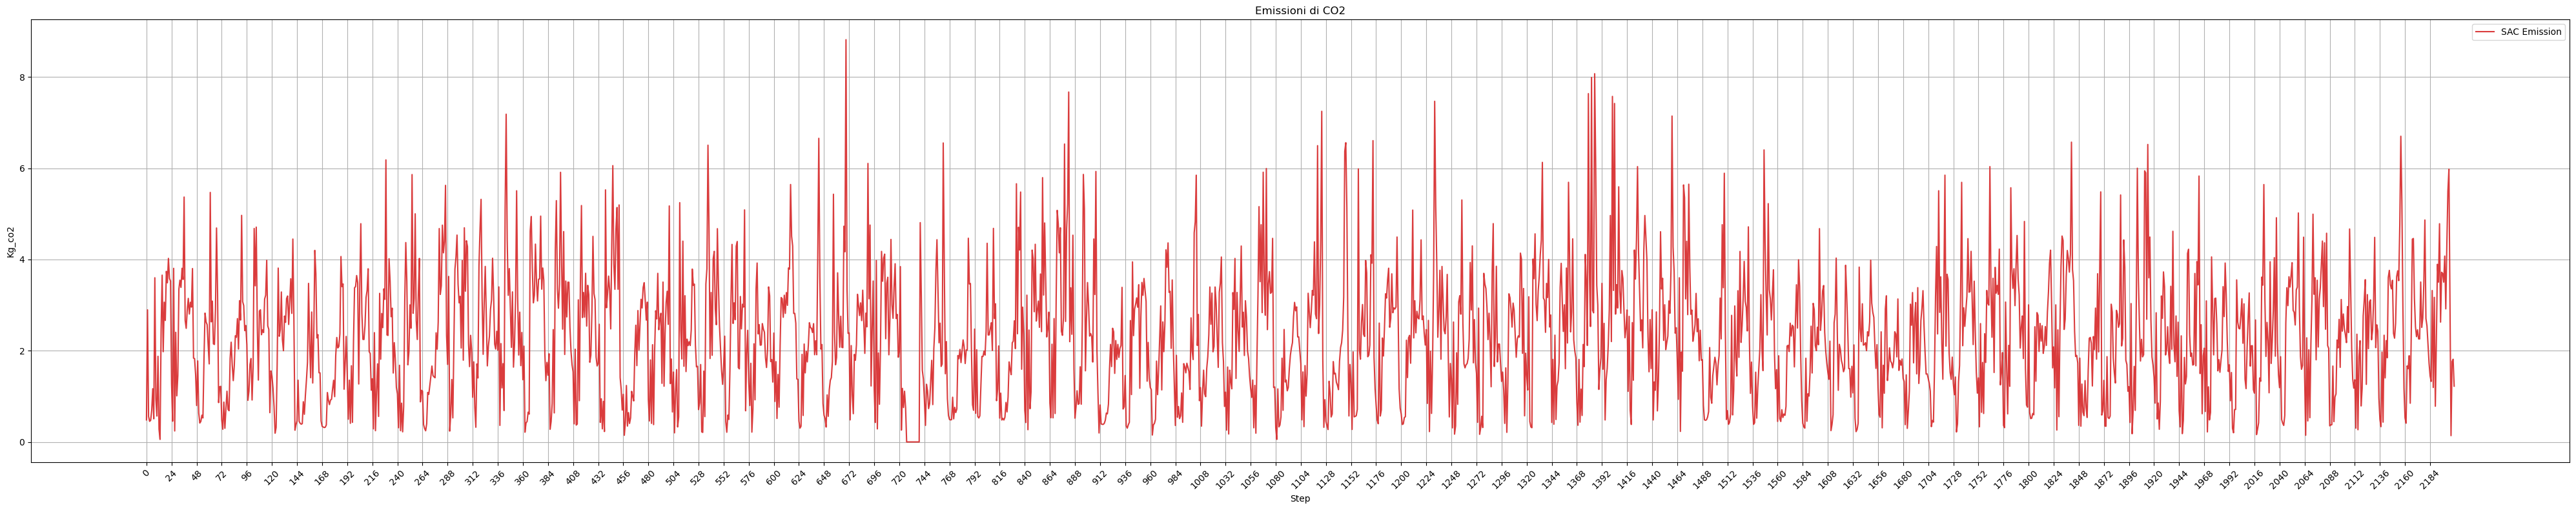

In [50]:
agent_data1 = test_env.unwrapped.net_electricity_consumption_emission

plt.plot_single_agent(agent_data1, ylabel='Kg_co2', title='Emissioni di CO2',label='SAC Emission')


----

## **Comportamento dei reward e dell'apprendimento**



In [52]:
df = plt.create_episode_table(test_env.unwrapped.episode_rewards)

display(Markdown(f"### **SAC - Base Version**"))
display(Markdown("----"))
display(df)




### **SAC - Base Version**

----

,Episodio,Reward Min,Reward Max,Reward Somma,Reward Media
0,1,-395.09671,-1.882936,-213163.296875,-96.585091
